# Alternative Models: Eager Learners I

<hr>

* Logistic Regression
* Decision Trees

In [1]:
# Import needed libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
import optuna
from optuna.samplers import GPSampler
import sklearn
import sklearn.ensemble

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [2]:
# ---------------------------------------------------------------------------- #
#                                PRE-PROCESSING                                #
# ---------------------------------------------------------------------------- #

# --------------------------------- SETTINGS --------------------------------- #
Normalize = True
PC_Features = True
Test_Size = 0.2
Random_Seed = 82024
Torch = False
Cross_Validation = True

# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize target
df.loc[df['num'] != 0, 'num'] = 1

# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

# Normalize if requested
if (Normalize) or (PC_Features):
    int_features, cat_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],\
    ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ])
    X = preprocessor.fit_transform(X)
else:
    X = X.values

# Apply PCA if requested
if PC_Features:
    pca = PCA(n_components=12)
    X = pca.fit_transform(X)

# Split train and test data
index = list(range(y.size))
train_index, test_index = train_test_split(index, test_size=Test_Size, random_state=Random_Seed)

train_X = X[train_index]
train_y = y.loc[train_index].values

test_X = X[test_index]
test_y = y.loc[test_index].values

# Convert to torch tensor if requested
if Torch:
    train_X, train_y, test_X, test_y = torch.tensor(train_X),\
    torch.tensor(train_y).double(), torch.tensor(test_X), torch.tensor(test_y).double()

<hr>

## Logistic Regression:

In [3]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = LogisticRegression(random_state=Random_Seed)

if Cross_Validation:
    cv_results = cross_validate(model, X, y, scoring=['accuracy', 'roc_auc'])
    acc = cv_results['test_accuracy'].mean()
    roc_auc = cv_results['test_roc_auc'].mean()
else:
    # Train model
    model.fit(train_X, train_y)

    # Test model
    y_pred = model.predict(test_X)
    pred_probs = model.predict_proba(test_X)

    # Evaluation
    acc = accuracy_score(test_y, y_pred)
    roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.8416
AUC-ROC: 0.9193


In [4]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Objective function
def objective(trial):
    # Faixa de parâmetros para otimizar
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)  # Parâmetro de regularização
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  # Solver

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    penalty = 'l2' if solver != 'liblinear' else penalty

    # Definindo o modelo de regressão logística
    clf = sklearn.linear_model.LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=1000)

    # Otimizando a média da validação cruzada
    return sklearn.model_selection.cross_val_score(clf, X, y, scoring = 'roc_auc').mean() #Estamos otimizando o score da validação cruzada


# Executando o optuna
study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
study.optimize(objective, n_trials=100) #Rodar a otimização

/tmp/ipykernel_15378/555016442.py:22: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
[I 2024-10-21 17:56:29,431] A new study created in memory with name: no-name-e7e93e69-2f9e-4569-a80a-d762b3c40c1b
[I 2024-10-21 17:56:29,466] Trial 0 finished with value: 0.8863343253968253 and parameters: {'C': 1.2157733076441402e-05, 'solver': 'saga', 'penalty': 'l2'}. Best is trial 0 with value: 0.8863343253968253.
[I 2024-10-21 17:56:29,487] Trial 1 finished with value: 0.5 and parameters: {'C': 0.00016392737019054683, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 0 with value: 0.8863343253968253.
[I 2024-10-21 17:56:29,511] Trial 2 finished with value: 0.9206514550264551 and parameters: {'C': 0.9769954216962461, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 2 with value: 0.9206514550264

In [5]:
# Mostrando o melhor modelo
trial = study.best_trial
print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

AUC-ROC: 0.9235945767195766
Best hyperparameters: {'C': 0.4868602832282118, 'solver': 'liblinear', 'penalty': 'l1'}


In [6]:
# Visualizando a otimização
optuna.visualization.plot_optimization_history(study)

In [7]:
optuna.visualization.plot_slice(study)

In [8]:
# Criando um modelo com os melhores hiperparâmetros
best_params = trial.params
model = LogisticRegression(random_state=Random_Seed, **best_params)

if Cross_Validation:
    cv_results = cross_validate(model, X, y, scoring=['accuracy', 'roc_auc'])
    acc = cv_results['test_accuracy'].mean()
    roc_auc = cv_results['test_roc_auc'].mean()
else:
    # Train model
    model.fit(train_X, train_y)

    # Test model
    y_pred = model.predict(test_X)
    pred_probs = model.predict_proba(test_X)

    # Evaluation
    acc = accuracy_score(test_y, y_pred)
    roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.8416
AUC-ROC: 0.9236


<hr>

## Decision Tree:

Accuracy: 0.7477
AUC-ROC: 0.7434


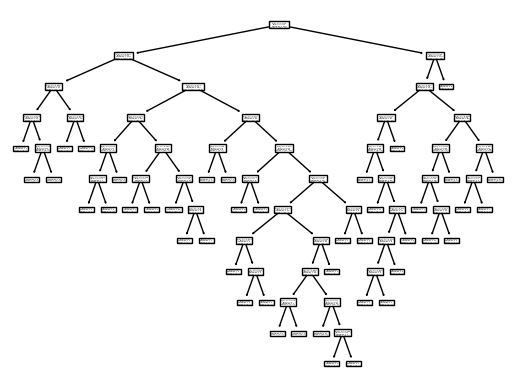

In [9]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = tree.DecisionTreeClassifier(random_state=Random_Seed)

if Cross_Validation:
    cv_results = cross_validate(model, X, y, scoring=['accuracy', 'roc_auc'])
    acc = cv_results['test_accuracy'].mean()
    roc_auc = cv_results['test_roc_auc'].mean()
else:
    # Train model
    model.fit(train_X, train_y)

    # Test model
    y_pred = model.predict(test_X)
    pred_probs = model.predict_proba(test_X)

    # Evaluation
    acc = accuracy_score(test_y, y_pred)
    roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

model.fit(X, y)
plot = tree.plot_tree(model)

In [10]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Objective function
def objective(trial):
    # Sugerindo valores para hiperparâmetros da árvore de decisão
    max_depth = int(trial.suggest_int('max_depth', 1, 32))  # Faixa para max_depth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Faixa para min_samples_split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Faixa para min_samples_leaf
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])  # Critério de divisão

    # Inicializando o modelo com os hiperparâmetros sugeridos
    clf = sklearn.tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )
    # Otimizando a média da validação cruzada
    return sklearn.model_selection.cross_val_score(clf, X, y, scoring = 'roc_auc').mean() #Estamos otimizando o score da validação cruzada

# Executando o optuna
study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
study.optimize(objective, n_trials=100) #Rodar a otimização

/tmp/ipykernel_15378/3000755595.py:24: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2024-10-21 17:57:02,980] A new study created in memory with name: no-name-f2c1065d-a1db-41a9-b592-6282f9045b66
[I 2024-10-21 17:57:03,009] Trial 0 finished with value: 0.8259300595238095 and parameters: {'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8259300595238095.
[I 2024-10-21 17:57:03,024] Trial 1 finished with value: 0.8193163029100529 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.8259300595238095.
[I 2024-10-21 17:57:03,039] Trial 2 finished with value: 0.8148892195767197 and parameters: {'max_depth': 31, 'min_samples_split': 11, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.8259300595238095.
[I 2024-10-21 17:57:03,053] Trial 3 finished w

In [11]:
# Mostrando o melhor modelo
trial = study.best_trial
print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

AUC-ROC: 0.8356977513227515
Best hyperparameters: {'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 11, 'criterion': 'gini'}


In [12]:
# Visualizando a otimização
optuna.visualization.plot_optimization_history(study)

In [13]:
optuna.visualization.plot_slice(study)

Accuracy: 0.7270
AUC-ROC: 0.8351


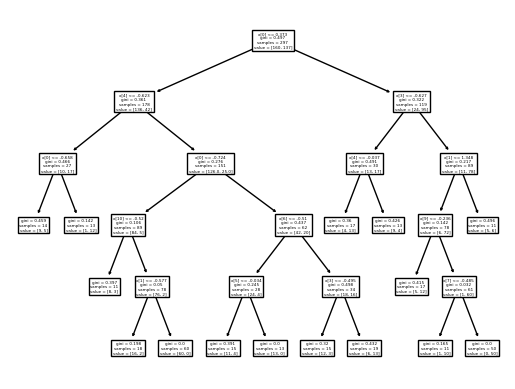

In [14]:
# Criando um modelo com os melhores hiperparâmetros
best_params = trial.params
model = tree.DecisionTreeClassifier(random_state=Random_Seed, **best_params)

if Cross_Validation:
    cv_results = cross_validate(model, X, y, scoring=['accuracy', 'roc_auc'])
    acc = cv_results['test_accuracy'].mean()
    roc_auc = cv_results['test_roc_auc'].mean()
else:
    # Train model
    model.fit(train_X, train_y)

    # Test model
    y_pred = model.predict(test_X)
    pred_probs = model.predict_proba(test_X)

    # Evaluation
    acc = accuracy_score(test_y, y_pred)
    roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

model.fit(X, y)
plot = tree.plot_tree(model)

### References:
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://scikit-learn.org/stable/modules/tree.html